In [1]:
#Camille L'Herminé

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

doc = r"C:\Users\camil\Documents\0.Msc-AI-Centrale\AIforfinance\WIKI_PRICES_212b326a081eacca455e13140d7bb9db.zip"
ret = pd.read_csv(doc)

**2) Data structure (columns and meaning)**

In [3]:
ret.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,A,1999-11-18,45.50,50.00,40.00,44.00,44739900.0,0.0,1.0,31.041951,34.112034,27.289627,30.018590,44739900.0
1,A,1999-11-19,42.94,43.00,39.81,40.38,10897100.0,0.0,1.0,29.295415,29.336350,27.160002,27.548879,10897100.0
2,A,1999-11-22,41.31,44.00,40.06,44.00,4705200.0,0.0,1.0,28.183363,30.018590,27.330562,30.018590,4705200.0
3,A,1999-11-23,42.50,43.63,40.25,40.25,4274400.0,0.0,1.0,28.995229,29.766161,27.460188,27.460188,4274400.0
4,A,1999-11-24,40.13,41.94,40.00,41.06,3464400.0,0.0,1.0,27.378319,28.613174,27.289627,28.012803,3464400.0


Comment on columns:
 - date: the trading day that we convert to datetime
  We note that there are missing dates due to holidays and we will fill them with ffil (with the previous value available)
 - ticker: the identifier for each stock. (we will separate them, in order to calculate the returns, by creating a pivot table with a ticker per line)
 - adj_close: the close price adjusted for dividends and stock splits that we use to compute returns to ensure they reflect the true total return.
 - volume: number of shares traded (if no volume is traded, we remove the data to avoid noise, we want the data of active trading days only)

In [4]:
ret.ticker.unique()

array(['A', 'AA', 'AAL', ..., 'ZQK', 'ZTS', 'ZUMZ'],
      shape=(3199,), dtype=object)

**3) Restrict the sample period**

In [5]:
ret['date'] = pd.to_datetime(ret['date'])


In [6]:
ret['date'].min()

Timestamp('1962-01-02 00:00:00')

In [7]:
ret['date'].max()

Timestamp('2018-03-27 00:00:00')

In [8]:
mask = (ret['date'] >= '2000-01-01') & (ret['volume'] > 0)
filtered_ret = ret.loc[mask].copy()

In [9]:
filtered_ret['date'].describe()

count                         11219607
mean     2009-11-23 21:21:31.947605248
min                2000-01-03 00:00:00
25%                2005-09-28 00:00:00
50%                2010-05-04 00:00:00
75%                2014-04-07 00:00:00
max                2018-03-27 00:00:00
Name: date, dtype: object

In [10]:
filtered_ret.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'volume',
       'ex-dividend', 'split_ratio', 'adj_open', 'adj_high', 'adj_low',
       'adj_close', 'adj_volume'],
      dtype='object')

**4) Build the matrix of daily adjusted returns**

In [11]:
price_mat = filtered_ret.pivot(index='date', columns='ticker', values='adj_close')
price_mat = price_mat.sort_index() #make sure the data is sorted by date

availability_mask = price_mat.notnull()

price_mat_filled = price_mat.ffill()  
# ffill ensures that even if a stock doesnt have a day of trading, 
# it carries the last known price so that once it does trade again
# we can calculate a valid return from that last known value and avoid NaN when using pct_change

return_mat = price_mat_filled.pct_change()

return_mat = return_mat.where(availability_mask)
# Without this, if a stock was delisted in 2015, ffill would carry its last price until 2018 
# pct_change() would then show a 0% return for years instead of desired NaN


In [12]:
return_mat.head()

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.076389,NaN,NaN,NaN,-0.003405,NaN,0.041481,NaN,-0.084331,NaN,...,NaN,-0.015111,-0.042553,NaN,NaN,NaN,NaN,-0.041864,NaN,NaN
2000-01-05,-0.074286,NaN,NaN,NaN,NaN,NaN,0.004979,NaN,0.014634,NaN,...,NaN,0.017260,0.022222,NaN,NaN,NaN,NaN,-0.017618,NaN,NaN
2000-01-06,-0.025341,NaN,NaN,NaN,NaN,NaN,0.008493,NaN,-0.086538,NaN,...,NaN,-0.050633,-0.043478,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2000-01-07,0.083333,NaN,NaN,NaN,NaN,NaN,-0.035088,NaN,0.047368,NaN,...,NaN,0.078014,-0.022727,NaN,NaN,NaN,NaN,0.000000,NaN,NaN


In [13]:
return_mat = return_mat.iloc[1:]
# we remove the very first row 
#(as it contains NaN since there was no previous day in the table to calculate the return)

We checked on yahoo finance for a few tickers:
- AAL (American Airlines), their IPO was in 2005 hence the removal for the period studied 2000-2018
- AAT, they had an IPO in 2011, same conclusion

These are typically columns that we will eliminate for our analysis (starting in 2000)

In [14]:
len(return_mat.columns)

3199

In [15]:
# We look at extreme returns with ticker and date (to verify online what happened)

print("TOP 10 BIGGEST POSITIVE RETURNS")
extreme_pos = return_mat.stack().sort_values(ascending=False).head(10)
for (date, ticker), ret in extreme_pos.items():
    print(f"{ticker} on {date.date()}: +{ret*100:.1f}%")

TOP 10 BIGGEST POSITIVE RETURNS
HERO on 2015-11-09: +28300.0%
EXXI on 2017-02-28: +24900.0%
BAGR on 2009-03-26: +10380.0%
GDP on 2017-04-11: +10280.4%
TXMD on 2011-10-31: +9900.0%
PCO on 2017-12-05: +9369.2%
HTWR on 2009-02-25: +8008.1%
BCEI on 2017-05-01: +7662.4%
TAM on 2013-04-18: +6699.1%
NES on 2017-10-12: +5751.4%


In [16]:
print("TOP 10 BIGGEST NEGATIVE RETURNS")
extreme_neg = return_mat.stack().sort_values(ascending=True).head(10)

for (date, ticker), ret in extreme_neg.items():
    print(f"{ticker} on {date.date()}: {ret*100:.1f}%")

TOP 10 BIGGEST NEGATIVE RETURNS
TXMD on 2011-09-29: -99.2%
BAGR on 2009-03-24: -99.0%
CHMT on 2010-11-10: -98.5%
HLS on 2003-03-26: -97.2%
CRRS on 2000-01-06: -96.0%
BAGR on 2010-05-19: -94.7%
NETE on 2011-09-20: -93.3%
CIE on 2017-06-26: -93.2%
GTAT on 2014-10-06: -92.8%
BAGR on 2011-04-14: -92.4%


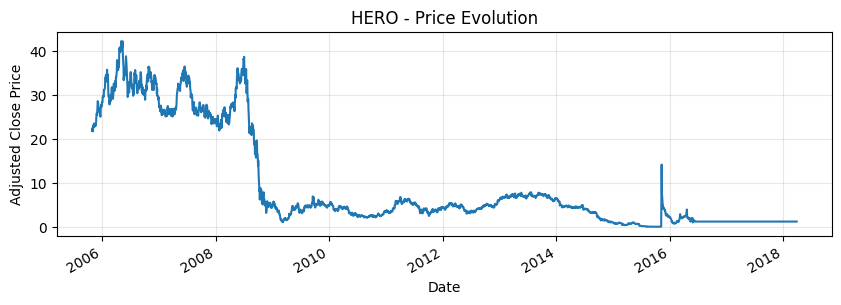

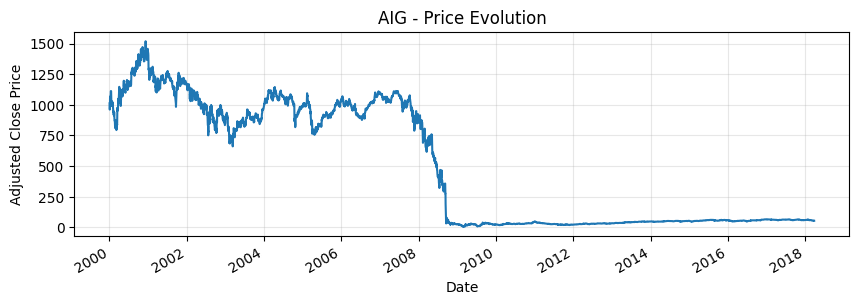

In [17]:
# Plot price evolution for tickers with extreme returns
# (to visually check if they are real events or data errors)

tickers_to_check = ['HERO', 'FNMA', 'FMCC', 'AIG', 'LEH']  # Some tickers with extreme moves

for ticker in tickers_to_check:
    if ticker in price_mat_filled.columns:
        plt.figure(figsize=(10, 3))
        price_mat_filled[ticker].dropna().plot()
        plt.title(f'{ticker} - Price Evolution')
        plt.xlabel('Date')
        plt.ylabel('Adjusted Close Price')
        plt.grid(True, alpha=0.3)
        plt.show()

In [18]:
# Investigation: HERO around 2015-11-09
ticker = 'HERO'
date_check = '2015-11-09'

print(f"Investigation of {ticker} around {date_check}\n")

print("Original prices (price_mat - before ffill):")
print(price_mat[ticker].loc['2015-11-01':'2015-11-15'].dropna())

print("\n" + "="*50 + "\n")

print("Price after ffil (price_mat_filled):")
print(price_mat_filled[ticker].loc['2015-11-01':'2015-11-15'])

print("\n" + "="*50 + "\n")

print("Returns calculated:")
print(return_mat[ticker].loc['2015-11-01':'2015-11-15'])

Investigation of HERO around 2015-11-09

Original prices (price_mat - before ffill):
date
2015-11-09    14.20
2015-11-10     9.50
2015-11-11     7.70
2015-11-12     7.05
2015-11-13     6.07
Name: HERO, dtype: float64


Price after ffil (price_mat_filled):
date
2015-11-02     0.05
2015-11-03     0.05
2015-11-04     0.05
2015-11-05     0.05
2015-11-06     0.05
2015-11-09    14.20
2015-11-10     9.50
2015-11-11     7.70
2015-11-12     7.05
2015-11-13     6.07
Name: HERO, dtype: float64


Returns calculated:
date
2015-11-02           NaN
2015-11-03           NaN
2015-11-04           NaN
2015-11-05           NaN
2015-11-06           NaN
2015-11-09    283.000000
2015-11-10     -0.330986
2015-11-11     -0.189474
2015-11-12     -0.084416
2015-11-13     -0.139007
Name: HERO, dtype: float64


### Data integrity check: "HERO" outlier
Observation: We detected extreme outliers in the calculated returns, most notably for Hercules Offshore, Inc. (HERO) around November 2015, which showed a single-day return exceeding 28,000%.

Explanation: This anomaly is a data error caused by an unadjusted reverse stock split following the company's Chapter 11 bankruptcy restructuring in late 2015. While the dataset recorded the new post-split price (jumping from ~$0.05 to ~$14.20), it failed to retroactively adjust the historical prices. This resulted in a calculation artifact where the change in share count was misinterpreted as a massive price appreciation.

Decision: We chose not to filter these extreme outliers. While they represent data artifacts rather than true market events, keeping them in the dataset allows us to: preserve raw WikiPrice data integrity and demonstrate that our survivorship bias conclusions are robust even under adverse data conditions. The robustness of our findings is validated in section 7.



In [19]:
#outlier_threshold = 3.0  # 3.0 = 300%
#return_mat[return_mat > outlier_threshold] = 0.0
#return_mat = return_mat.where(availability_mask)

In [20]:
print(f"Mean daily return: {return_mat.mean().mean()*100:.4f}%")
print(f"Std daily return: {return_mat.std().mean()*100:.2f}%")

Mean daily return: 0.0988%
Std daily return: 4.18%


**5) Survivor-bias experiment (two portfolio backtests)**

A)

In [21]:
# We identify stocks that exist at the start and at the very end of the sample.
#These are the survivors, the stocks that traded during the whole sample window 
first_valid_date = return_mat.index.min()
last_valid_date = return_mat.index.max()

survivor_mask = price_mat.loc[first_valid_date].notna() & price_mat.loc[last_valid_date].notna()
survivor_tickers = price_mat.columns[survivor_mask]
n_surv = len(survivor_tickers)
print(n_surv)

1389


In [22]:
portfolio_a_returns = return_mat[survivor_tickers].mean(axis=1)
#By using .mean(), we reset the weights to be equal every single day (daily rebalancing).

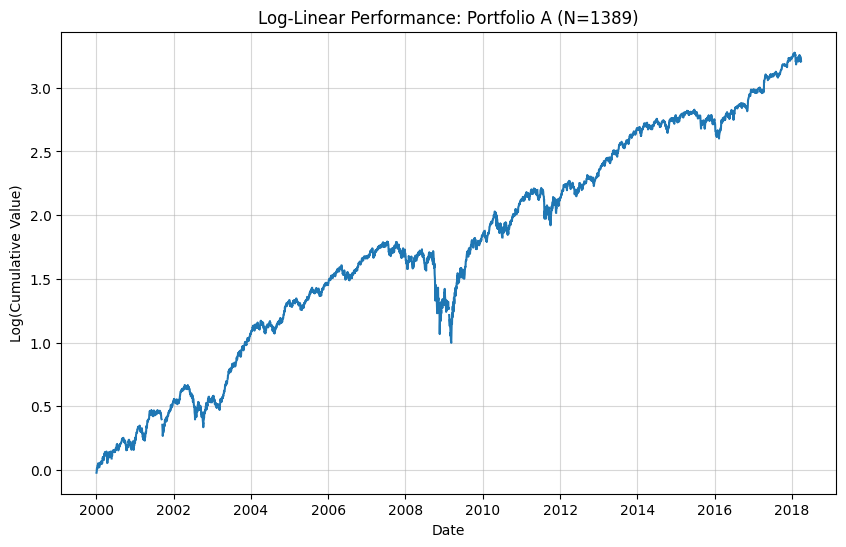

In [23]:
cumulative_value_a = (1 + portfolio_a_returns).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_value_a.index, np.log(cumulative_value_a))
plt.title(f'Log-Linear Performance: Portfolio A (N={n_surv})')
plt.ylabel('Log(Cumulative Value)')
plt.xlabel('Date')
plt.grid(alpha=0.5)
plt.show()

B)

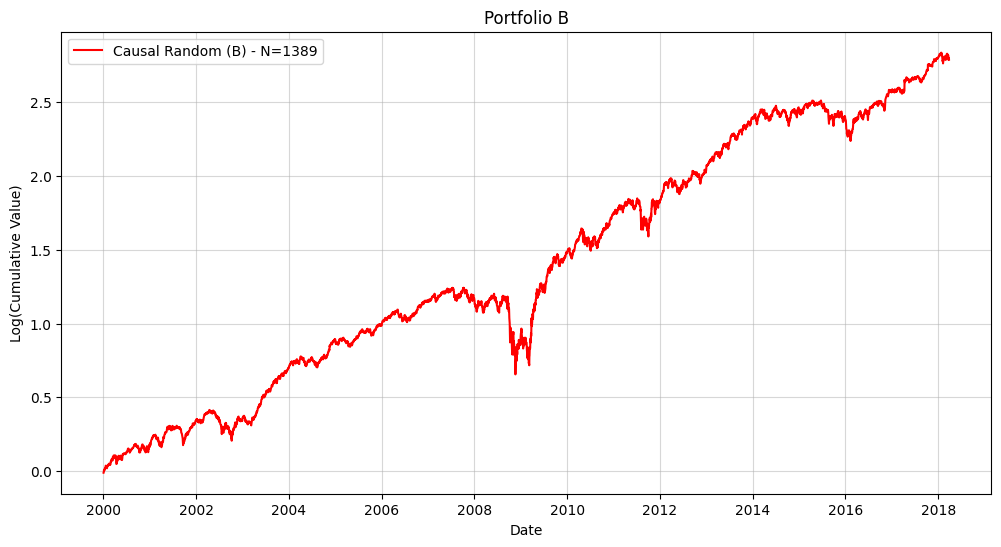

Portfolio B: 16.2944x


In [24]:
np.random.seed(42)
portfolio_b_corrected_list = []

for date, row in return_mat.iterrows():
    # Include all stocks (even those with NaN) by treating NaN as 0% return
    available_today = row.index
    row_filled = row.fillna(0)
    
    if len(available_today) >= n_surv:
        selected = np.random.choice(available_today, n_surv, replace=False)
        daily_ret = row_filled[selected].mean()
    else:
        daily_ret = row_filled.mean()
        
    portfolio_b_corrected_list.append(daily_ret)

portfolio_b_corrected_returns = pd.Series(portfolio_b_corrected_list, index=return_mat.index)
cumulative_value_b_corrected = (1 + portfolio_b_corrected_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(np.log(cumulative_value_b_corrected), label=f'Causal Random (B) - N={n_surv}', color='red')

plt.title('Portfolio B')
plt.ylabel('Log(Cumulative Value)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

print(f"Portfolio B: {cumulative_value_b_corrected.iloc[-1]:.4f}x")

**Comparison**

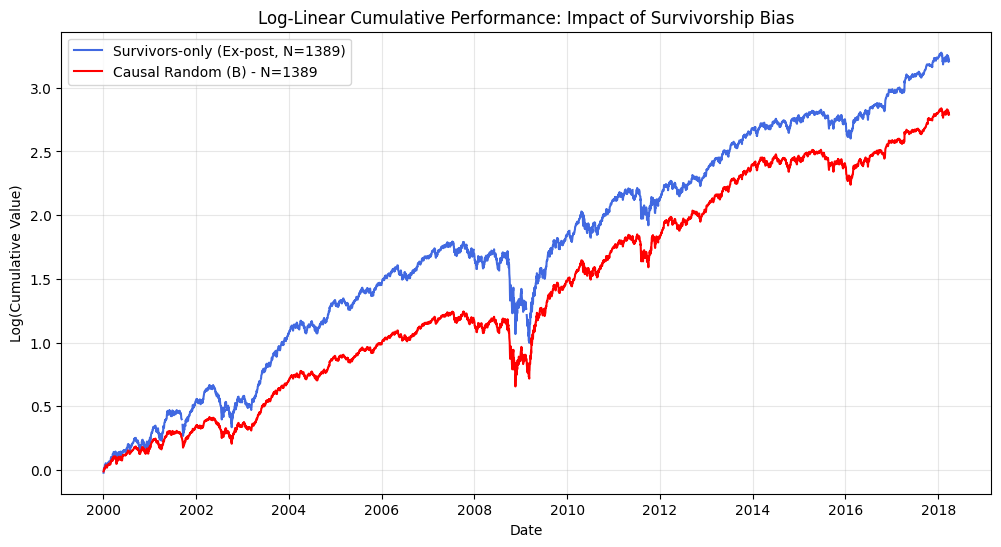

Number of survivors: 1389
Portfolio A (Survivors-only):
  Final cumulative value: 24.7517x
  Log(final value): 3.2089
  Total return %: 2375.17%
  Mean daily return: 0.079127%

Portfolio B (Causal day-by-day):
  Final cumulative value: 16.2944x
  Log(final value): 2.7908
  Total return %: 1529.44%
  Mean daily return: 0.065759%

Comparison:
  A/B ratio: 1.5190
  Outperformance: 51.90%


In [25]:
plt.figure(figsize=(12, 6))
plt.plot(np.log(cumulative_value_a), label=f'Survivors-only (Ex-post, N={n_surv})', color='royalblue')
plt.plot(np.log(cumulative_value_b_corrected), label=f'Causal Random (B) - N={n_surv}', color='red')

plt.title('Log-Linear Cumulative Performance: Impact of Survivorship Bias')
plt.xlabel('Date')
plt.ylabel('Log(Cumulative Value)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Number of survivors: {n_surv}")

final_a = cumulative_value_a.iloc[-1]
final_b = cumulative_value_b_corrected.iloc[-1]
print(f"Portfolio A (Survivors-only):")
print(f"  Final cumulative value: {final_a:.4f}x")
print(f"  Log(final value): {np.log(final_a):.4f}")
print(f"  Total return %: {(final_a - 1)*100:.2f}%")
print(f"  Mean daily return: {portfolio_a_returns.mean()*100:.6f}%")

print(f"\nPortfolio B (Causal day-by-day):")
print(f"  Final cumulative value: {final_b:.4f}x")
print(f"  Log(final value): {np.log(final_b):.4f}")
print(f"  Total return %: {(final_b - 1)*100:.2f}%")
print(f"  Mean daily return: {portfolio_b_corrected_returns.mean()*100:.6f}%")

print(f"\nComparison:")
print(f"  A/B ratio: {final_a/final_b:.4f}")
print(f"  Outperformance: {((final_a/final_b - 1)*100):.2f}%")

**6) Interpretation: explain the difference**

Portfolio A cumulative log return is higher than for Portfolio B, the gap increases especially after 2008, where the financial crisis triggered a lot of bankruptcy/delisting. Portfolio B contains stocks that will eventually go bankrupt or delist whereas A has been selected with a survivorship bias (stocks that are still listed in 2018). On the periods before some companies fail in protfolio B, the returns are often low, dragging down the average.

This gap shows the survivorship bias. It shows that an investor will overestimate the profit if they accidentally include future information in their backtest (notably only take firms that survived).

*Why selecting stocks that are present for the entire period is an ex-post filter that effectively conditions on survival.*

In the year 2000, an investor had no way of knowing which companies would survive. By applying the filter in portfolio A, we are only allowing companies into your portfolio that we already know did not go bankrupt, or were not delisted.
So it is an ex-post filter that conditions on survival, it's like telling the year-2000 investor insight of which firms are going to survive until 2018.

*How delisting events and the disappearance of poorly performing firms can mechanically create a survivorship bias in backtests that only keep long-lived stocks.*

Firms that don't perform well don't disappear instantly. They go through a phase of decay where stock prices drop, returns are negative, which drives down the cumulative log returns. So filtering for only the firms that survived is also like deleting these negative returns from the data. So the survivorship bias is an overestimation of this cumulative log returns.

*Why the day-by-day causal selection changes the experiment and can lead to different average performance and risk.*

Portfolio B introduces the uncertainty that we removed in portfolio A. By selecting stocks day by day without knowing which firms would survive, we pick stocks that will get delisted which experienc price drops before disappearing. Statistically, this allows to capture the extreme negative events. By sampling randomly each day, the portfolio B includes a broader range of companies, including those that go bankrupt or get delisted, much more like an investor would typically behave.

**7) Diagnostic note**

The number of survivors is not extremely small (1,389) compared to the initial number of stocks (3,199), representing 43.4% retention. This is expected given that our period (2000-2018) contains multiple significant crises including the 2008 financial crisis, which triggered substantial delisting and bankruptcy events.

**Data anomalies and their interpretation:**

Observation: HERO (Hercules Offshore) exhibits a +28,000% return spike in November 2015 due to an unadjusted reverse stock split during Chapter 11 bankruptcy restructuring.

Key insight: HERO delisted in 2015, which means it is NOT included in Portfolio A (Survivors-only: must have prices for both 2000-01-01 and 2018-12-31). However, HERO IS included in Portfolio B (Causal day-by-day) for all trading days up to its delisting in 2015.

Implication: This extreme outlier artificially inflates Portfolio B's performance during the 2015 period. Despite this upward bias benefiting the Causal portfolio, Portfolio A still significantly outperforms (24.75x vs 16.29x, representing ~52% outperformance).

Conclusion: We chose not to filter outliers > 300% to preserve raw dataset integrity. This decision actually strengthens our findings: it demonstrates that the survivorship bias effect is so powerful that it overcomes even these artificial data anomalies that favor Portfolio B. The magnitude of the bias is thus proven to be robust and not merely an artifact of data cleaning choices.

In [26]:
# Let's inspect a few examples of tickers and their trading history
existed_at_start = price_mat.loc[first_valid_date].notna()
missing_at_end = price_mat.loc[last_valid_date].isna()
fallen_mask = existed_at_start & missing_at_end
fallen_tickers = price_mat.columns[fallen_mask]

print(fallen_tickers[[17, 93, 176]].tolist())

['AMRI', 'DELL', 'IXYS']


We checked on yahoo finance for a few tickers:
- AMRI: Albany molecular research was acquired by the Carlyle group in 2017 hence it's disappearance from the data. We didn't consider this kind of case in our analysis for simplicity. But their return likely didn't drop before the disappearance.
- DELL : went private in 2013 and relisted in 2018 (after the end of the period we considered), it is not a bankruptcy but the privatization was decided after several targets were missed and they wanted to focus on long-term strategy rather than short-term profit to prevent the share price from dropping too much.
- IXYS: IXYS Corporation publicly traded but was acquired by Littelfuse in January 2018. (same case figure as AMRI)